In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

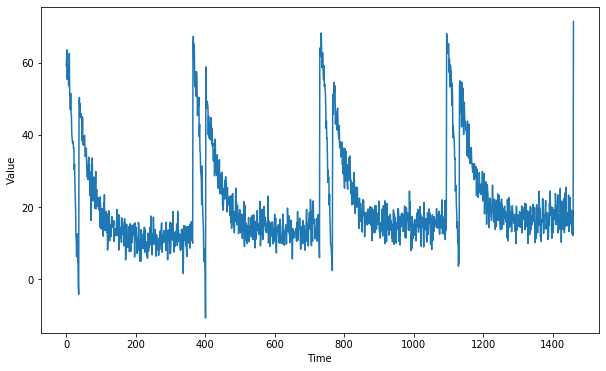

In [4]:
def generate_time_series():
    time = np.arange(4*365+1, dtype="float32")
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    amplitude = 50
    series+=seasonality(time, period=365, amplitude=amplitude)

    noise_level=3
    series+=noise(time, noise_level, seed=51)
    return time, series

@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [5]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [8]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)
batch_of_features, batch_of_labels = next((iter(test_dataset)))

In [10]:
def create_model(window_size = G.WINDOW_SIZE):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

    return model

In [11]:
dataset = windowed_dataset(series_train)
model = create_model()

model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 5ms/step - loss: 141.5838
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 108.5538
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 88.1362
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 76.4810
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 68.2217
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 62.2774
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 57.3468
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 53.6255
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 51.4935
Epoch 10/100
34/34 [==============================] - 0s 2ms/step - loss: 49.3268
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 47.0811
Epoch 12/100
34/34 [==============================] - 0s 2ms/step - loss: 46.0541
Epoch 13/100
34/34 [===

In [12]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

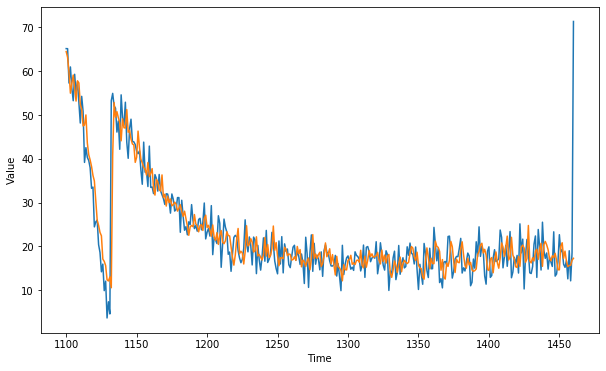

In [13]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results
dnn_forecast = generate_forecast()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [14]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 28.69, mae: 3.38 for forecast


In [15]:
model.save('my_model.h5')